In [46]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'/Users/ryan/github/prosodic')
from llmdh import *
from prosodic import Word
from tinydb import TinyDB, Query
prosodic.USE_CACHE=False
import plotnine as p9
from sqlitedict import SqliteDict


In [54]:
path_db=os.path.join(PATH_DATA,'sqlitedict_poems.db')
db=SqliteDict(path_db, autocommit=True)

In [121]:
def get_rhyme_data(db, force=False, min_lines=8):
    o=[]
    for key in tqdm(list(db.keys())):
        data = db[key]
        if force or not 'num_rhyming_lines' in data:
            with prosodic.logmap.verbosity(0):
                poem = prosodic.Text(data['poem'])
                llist = prosodic.LineList(
                    l
                    for st in poem.stanzas
                    for l in st.lines
                    if len(st.lines)>1
                    and len(l.wordtokens)>1
                )
                data['num_lines'] = len(llist)
                if data['num_lines']:
                    rhymes=llist.get_rhyming_lines(max_dist=1)
                    rhymeset = set(rhymes.keys()) | set(v[1] for v in rhymes.values())
                    data['num_rhyming_lines'] = len(rhymeset)
                    data['perc_rhyming_lines'] = data['num_rhyming_lines'] / data['num_lines'] * 100
                else:
                    data['num_rhyming_lines'] = np.nan
                    data['perc_rhyming_lines'] = np.nan
                db[key] = data
        if data['num_lines']>=min_lines:
            o.append(data)
    return pd.DataFrame(o).dropna()

df=get_rhyme_data(db,force=False)

100%|██████████| 4207/4207 [00:28<00:00, 148.24it/s]  


In [122]:
df

,model,temp,prompt,poem,num_lines,num_rhyming_lines,perc_rhyming_lines
0,gpt-3.5-turbo,0.604203,Write an unryhmed poem in the style of Shakesp...,"To be or not to be, that is the question\nWhet...",35,13,37.142857
1,gemini-pro,0.084931,Write a poem (with 20+ lines) that does NOT rh...,"**Unbound**\n\nIn the realm of thoughts, where...",24,7,29.166667
2,gpt-3.5-turbo,1.151316,Write an unryhmed poem in the style of Shakesp...,"To be or not to be, that is the question\nWhet...",14,3,21.428571
3,gpt-3.5-turbo,0.539564,Write a long poem that does NOT rhyme.,"In the stillness of the night, I lay awake\npo...",24,2,8.333333
4,gpt-3.5-turbo,1.100352,Write an unryhmed poem in the style of Shakesp...,"To speak my mind, my thoughts untold,\nA heart...",20,4,20.000000
...,...,...,...,...,...,...,...
3778,claude-3-sonnet-20240229,0.403658,Write an unryhmed poem in the style of Shakesp...,Here is an attempt at an unrhymed poem in the ...,14,14,100.000000
3779,claude-3-opus-20240229,0.639519,Write a poem in the style of e.e. cummings,Here is an original poem in the style of e.e. ...,30,2,6.666667
3780,claude-3-sonnet-20240229,0.345846,Write a poem in the style of e.e. cummings,Here's an attempt at a poem in the style of e....,14,0,0.000000
3781,claude-3-opus-20240229,0.471001,Write a poem that does NOT rhyme.,"In the stillness of the night,\nA whisper echo...",16,3,18.750000


In [134]:

excl_prompts=[
    # 'Write an unryhmed poem in the style of Shakespeare\'s dramatic monologues.',
    'Write a poem in the style of e.e. cummings',
    # 'Write a poem in the style of Walt Whitman.',
    'Write a poem in the style of Wallace Stevens.',
    'Continue the following poem:\n\nTyping, typing, fingers on the keyboard\nThe keys crack and bend under sweat and weight,\n'
]
figdf=df[~df.prompt.isin(excl_prompts)]
figdf=pd.concat(gdf for g,gdf in figdf.groupby(['model','prompt']) if len(gdf)>5)
figdf['model']=['-'.join(x.split('-')[:3]).replace('-uncensored','-uncens') for x in figdf['model']]
for k in ['model','prompt']:
    figdf[k] = pd.Categorical(
        figdf[k], 
        categories=figdf.groupby(k).perc_rhyming_lines.median().sort_values(ascending=False).index,
    )
figdf

,model,temp,prompt,poem,num_lines,num_rhyming_lines,perc_rhyming_lines
668,claude-3-haiku,0.167888,Write a long poem that does NOT rhyme.,Here is a long poem that does not rhyme:\n\nEc...,32,4,12.500000
1350,claude-3-haiku,0.221379,Write a long poem that does NOT rhyme.,Here is a long poem that does not rhyme:\n\nEc...,36,2,5.555556
1653,claude-3-haiku,0.287636,Write a long poem that does NOT rhyme.,Here is a long poem that does not rhyme:\n\nTh...,28,2,7.142857
1693,claude-3-haiku,0.370762,Write a long poem that does NOT rhyme.,Here is a long poem that does not rhyme:\n\nEc...,36,5,13.888889
2085,claude-3-haiku,0.748824,Write a long poem that does NOT rhyme.,Here is a long poem that does not rhyme:\n\nRe...,40,3,7.500000
...,...,...,...,...,...,...,...
3518,llama2-uncens:7b,1.052211,Write an unryhmed poem in the style of Shakesp...,"I am a storm, I roar and rage, \nThrough the n...",18,0,0.000000
3536,llama2-uncens:7b,1.232407,Write an unryhmed poem in the style of Shakesp...,"In a kingdom far away, there dwelt a queen;\nH...",18,2,11.111111
3542,llama2-uncens:7b,1.412505,Write an unryhmed poem in the style of Shakesp...,"In twilight, when shadows fall upon the land,\...",8,6,75.000000
3544,llama2-uncens:7b,0.263968,Write an unryhmed poem in the style of Shakesp...,"I am a creature of the night,\nA shadow on the...",20,6,30.000000


In [139]:
p9.options.figure_size=11,8
# fig=p9.ggplot(figdf, p9.aes(x='num_rhyming_lines', y='num_lines', fill='num_poems'))
# fig+=p9.geom_tile()
# fig+=p9.facet_grid('model~prompt')
# fig

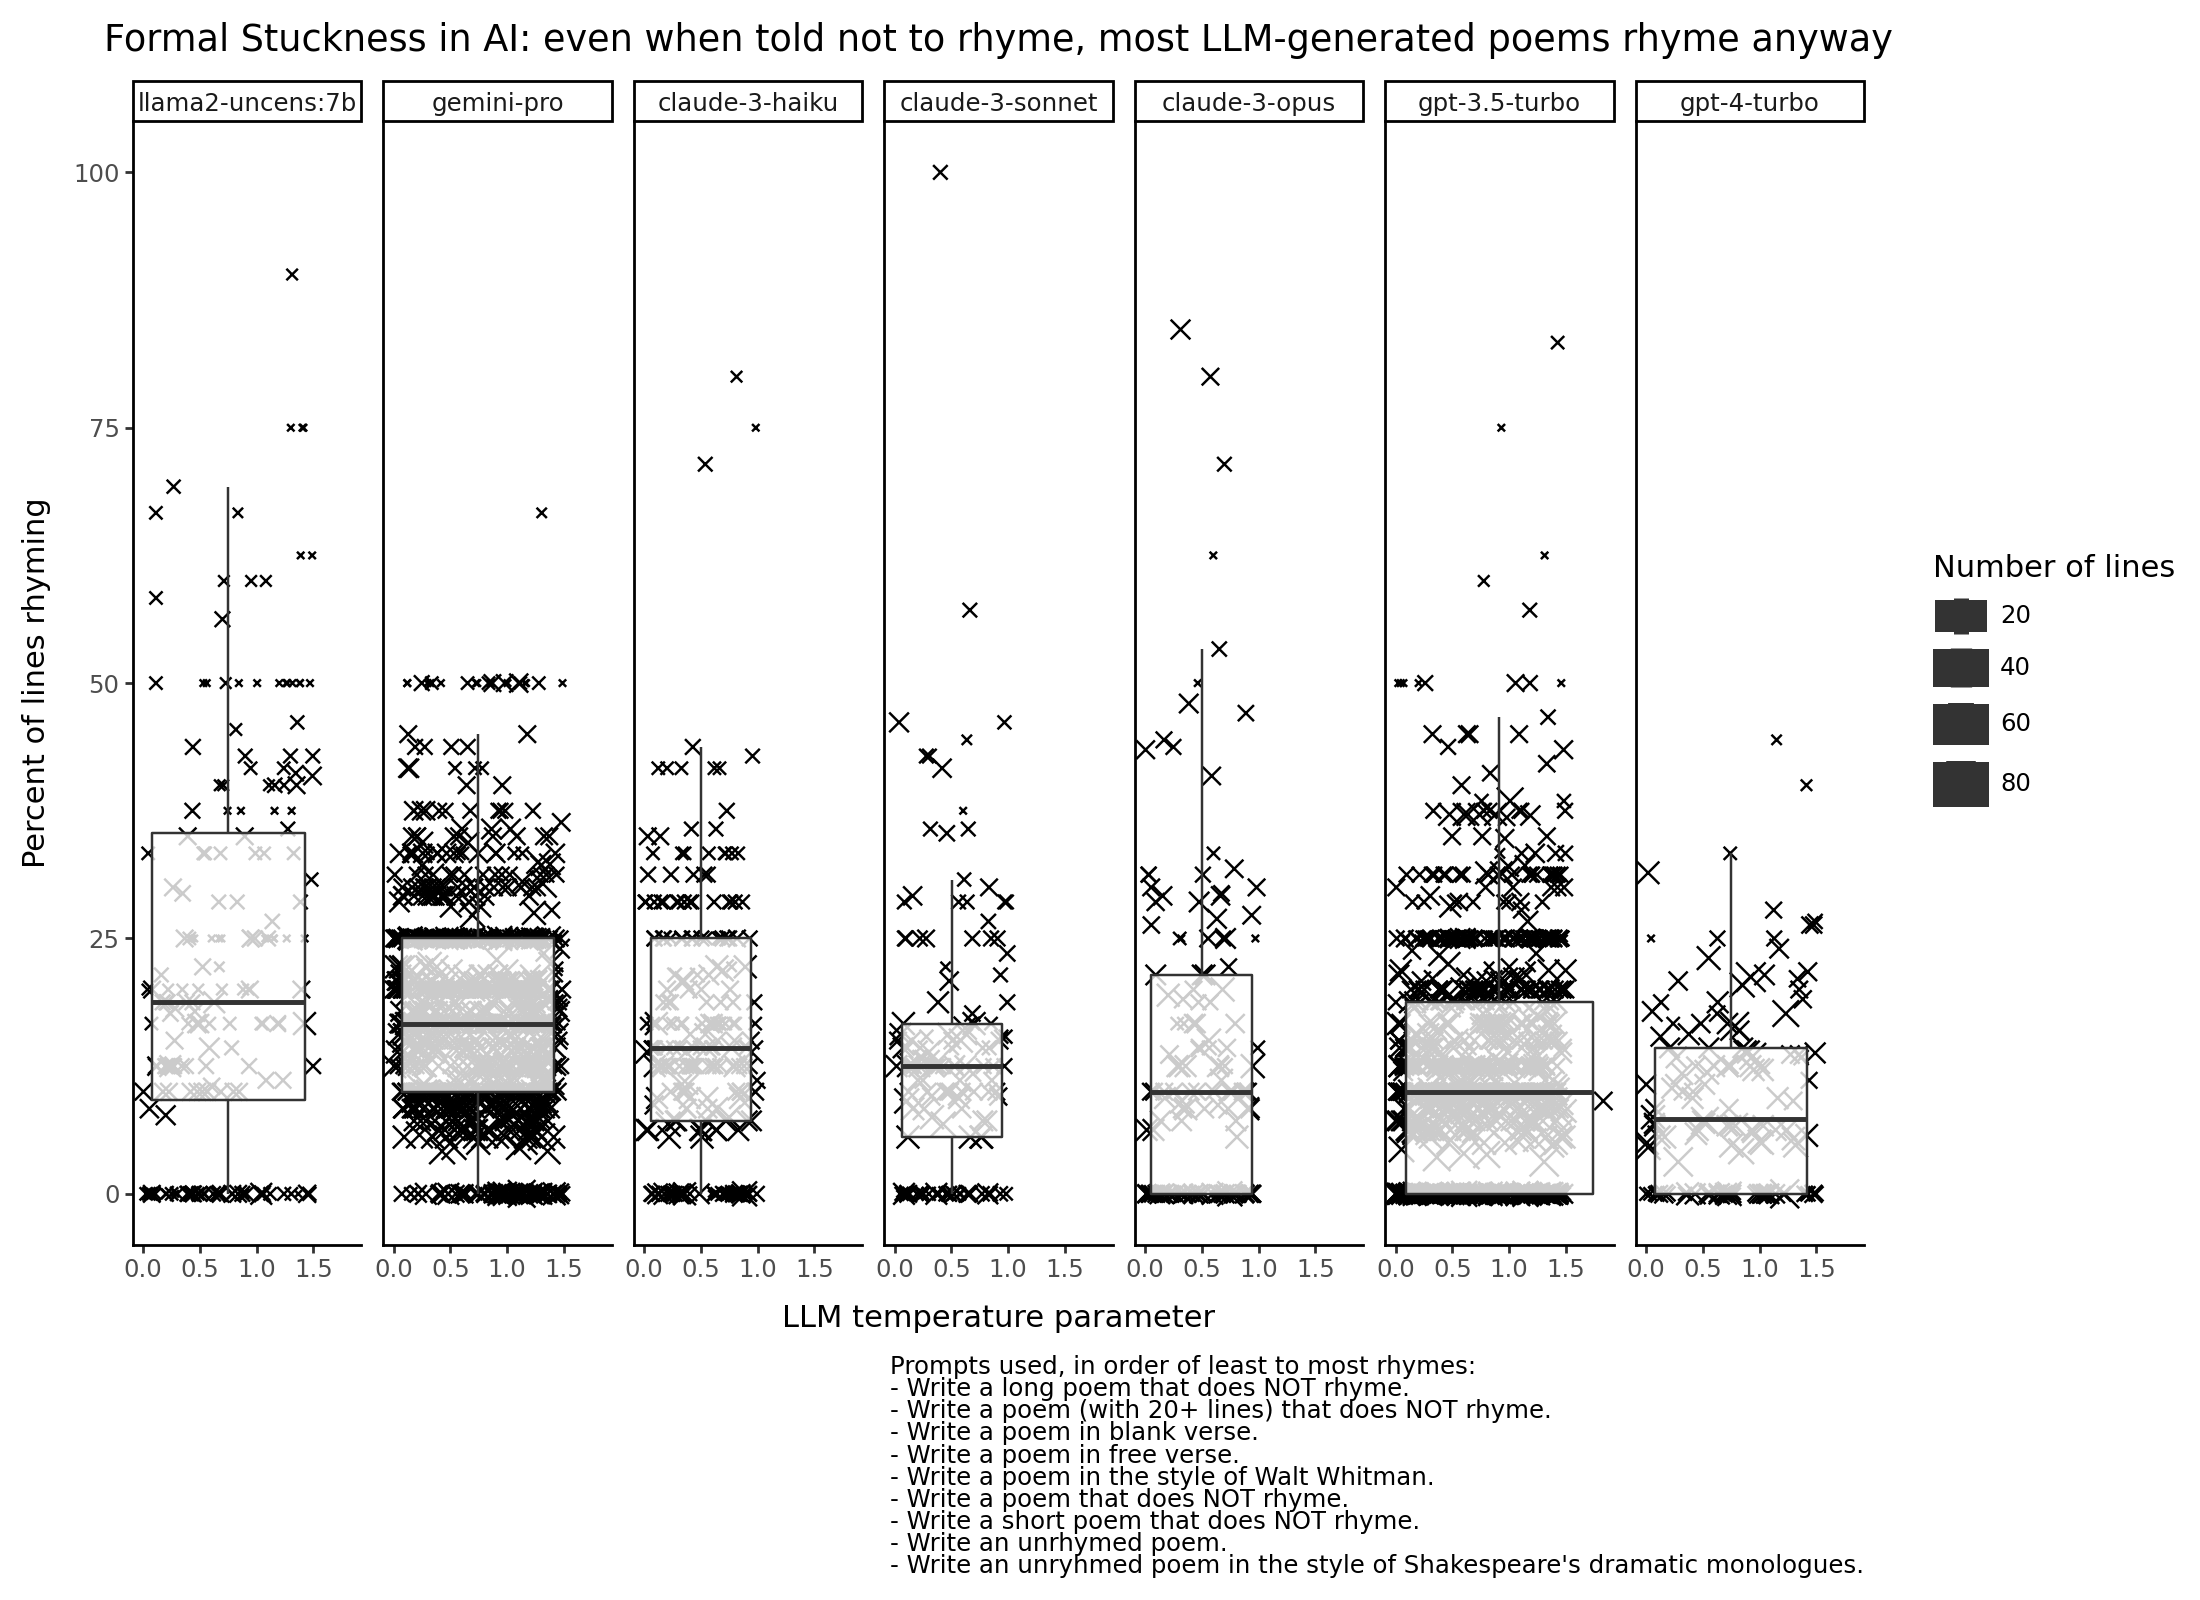

In [149]:
fig=p9.ggplot(figdf, p9.aes(x='temp', y='perc_rhyming_lines', size='num_lines'))
fig+=p9.theme_classic()
# fig+=p9.geom_violin(alpha=.75)
fig+=p9.geom_point(shape='x')
fig+=p9.geom_boxplot(alpha=.8, outlier_shape='')
# fig+=p9.geom_smooth()
# fig+=p9.facet_grid('model~prompt')
fig+=p9.facet_wrap('model', ncol=7)
fig+=p9.labs(
    title="Formal Stuckness in AI: even when told not to rhyme, most LLM-generated poems rhyme anyway",
    y='Percent of lines rhyming',
    x='LLM temperature parameter',
    size='Number of lines',
    caption='Prompts used, in order of least to most rhymes:\n- '+'\n- '.join(figdf.prompt.unique())
)
fig.save('fig.rhyme_box_plots.png')
fig

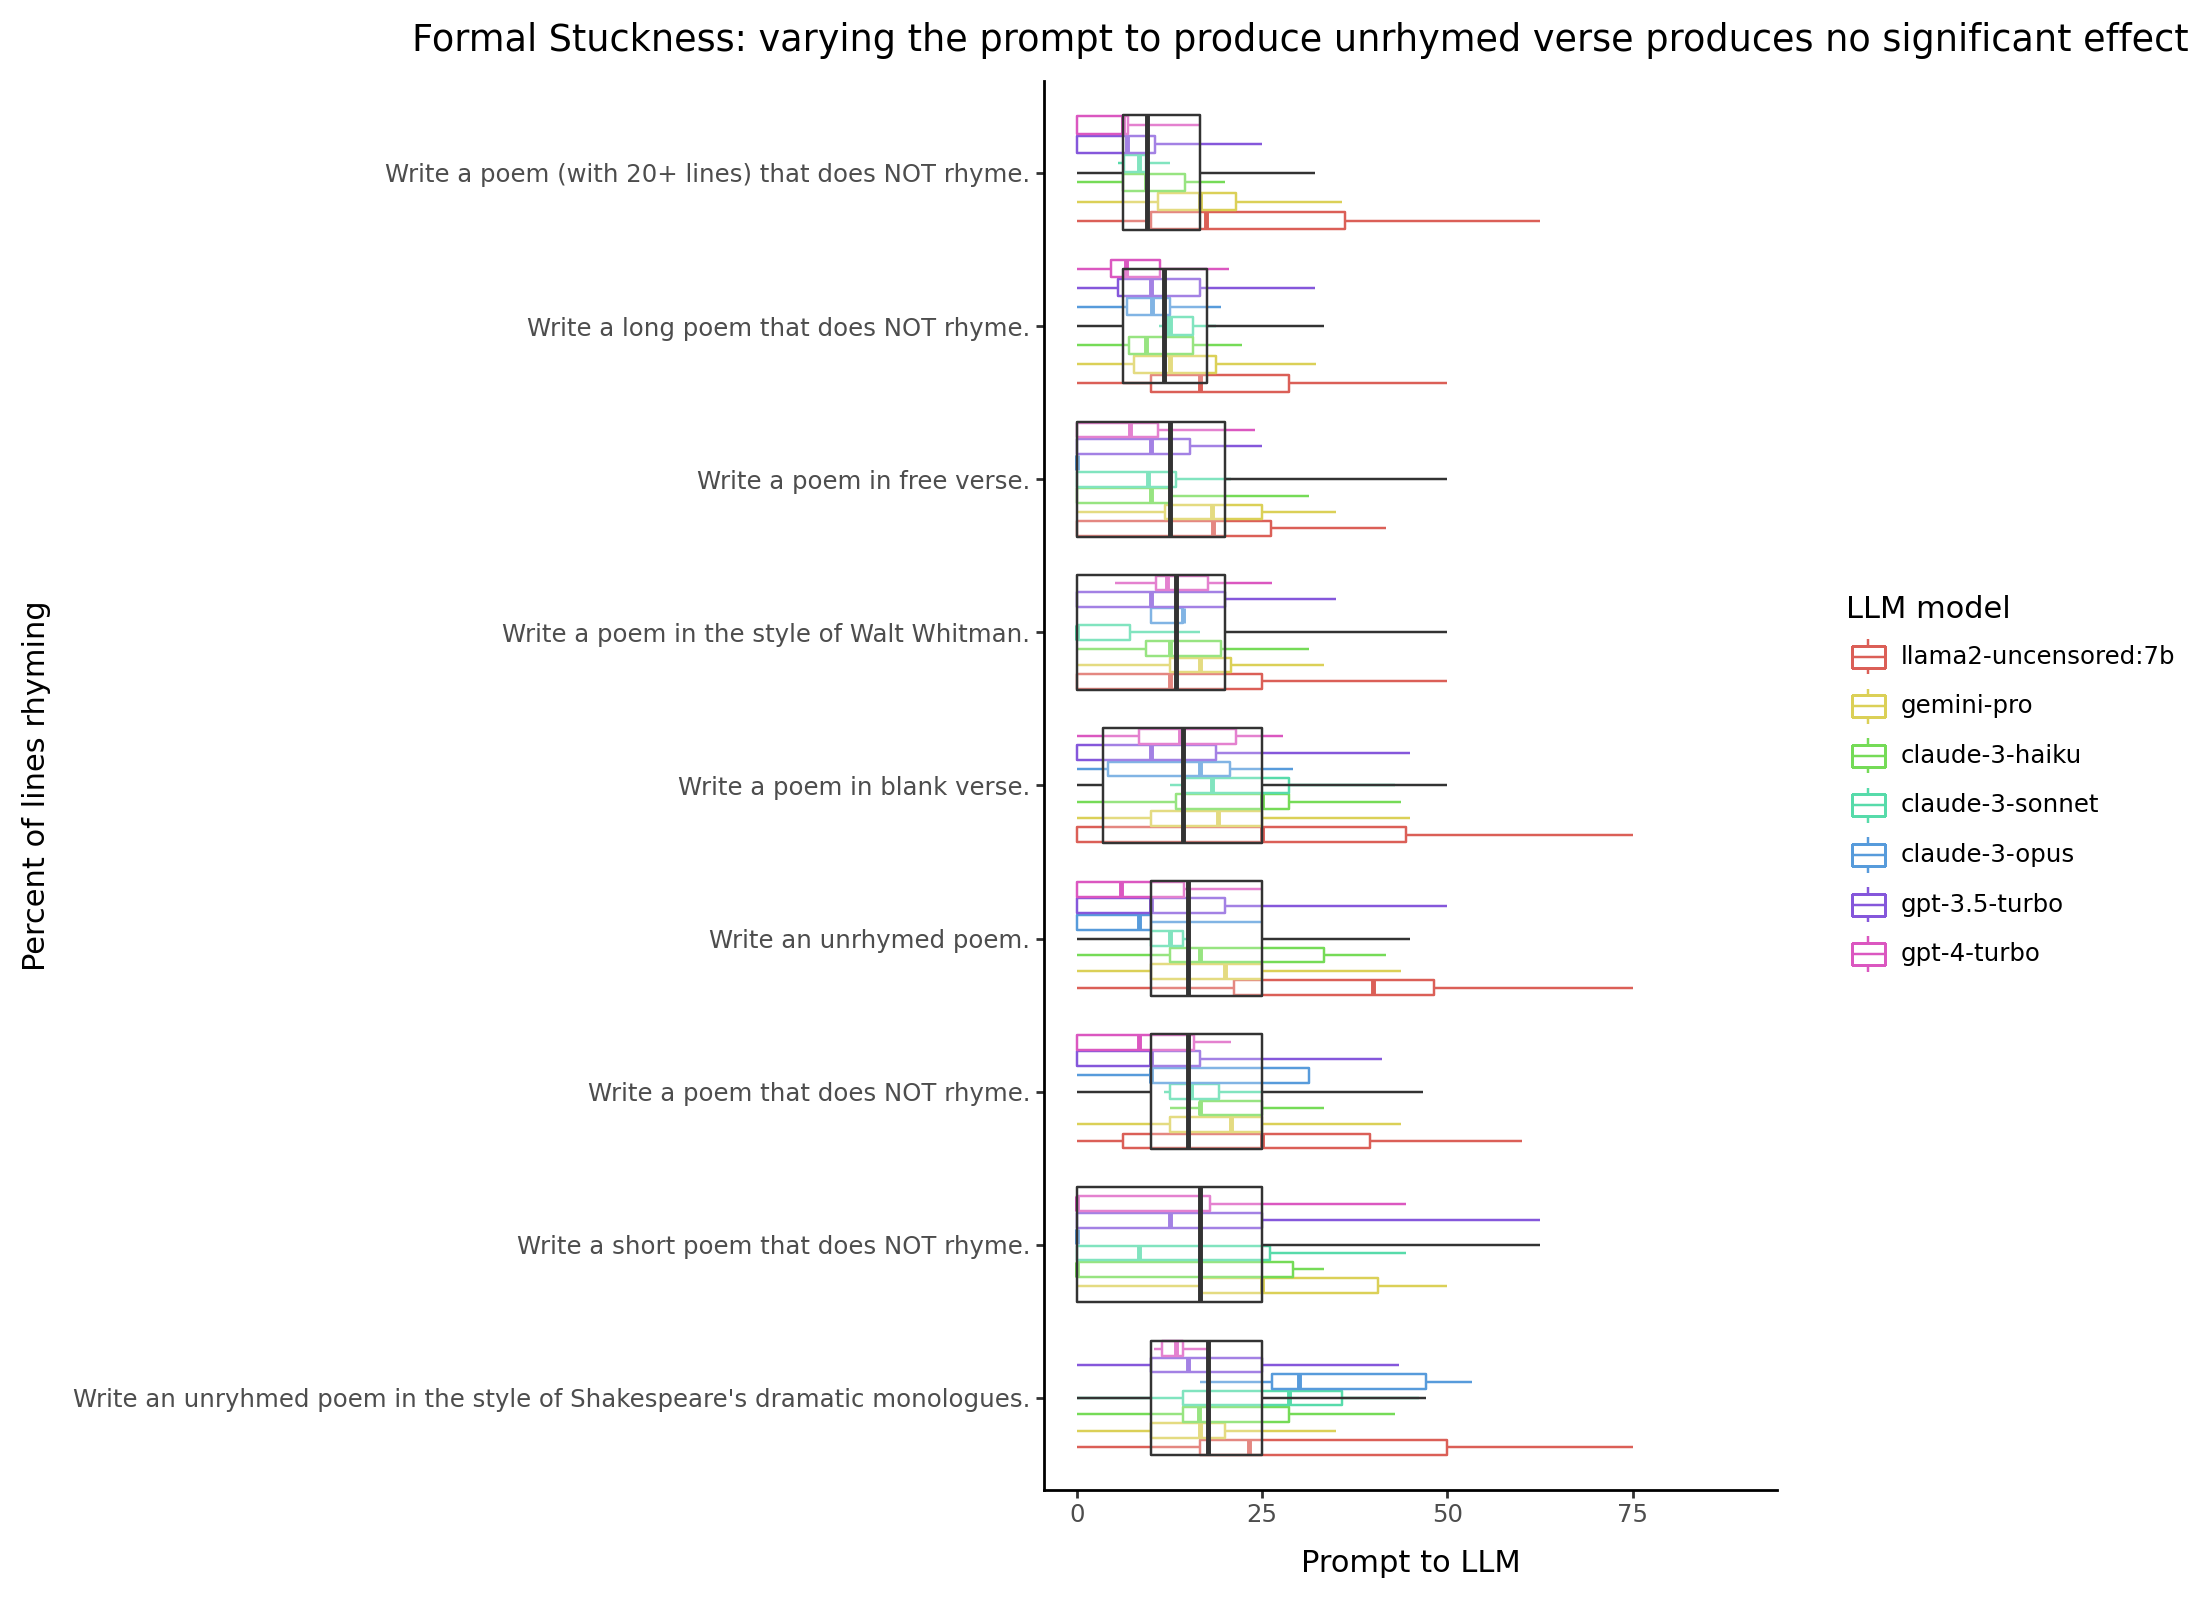

In [111]:

fig=p9.ggplot(figdf, p9.aes(x='prompt', y='perc_rhyming_lines', size='num_lines'))
fig+=p9.theme_classic()
fig+=p9.geom_boxplot(p9.aes(color='model'), alpha=.5, outlier_shape='')
fig+=p9.geom_boxplot(alpha=.25, outlier_shape='')
# fig+=p9.geom_point(shape='x')
# fig+=p9.facet_grid('model~prompt')
# fig+=p9.facet_wrap('model')
fig+=p9.coord_flip()
fig+=p9.labs(
    title='Formal Stuckness: varying the prompt to produce unrhymed verse produces no significant effect on rhyming',
    x='Percent of lines rhyming',
    y='Prompt to LLM',
    color='LLM model'
)
fig